In [1]:
from pycuber_sc import Cube
import numpy as np
import tensorflow as tf
from collections import deque
import itertools
import sys
from collections import defaultdict
import json
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [30, 10]
import pandas as pd

/home/songci/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


动作空间大小为12
```yaml
u: up #上面顺时针旋转
d: down
l: left
...
u': up prime #上面逆时针旋转

```

In [2]:
# read this http://rubiks.wikia.com/wiki/Notation
action_space = ['u', 'd', 'l', 'r', 'f', 'b', 'u\'', 'd\'', 'l\'', 'r\'', 'f\'', 'b\'']

In [3]:
class Env:
    def __init__(self, tweaked_times_limit=100, tweaked_times=1):
        """
        @param tweaked_times_limit 放弃旋转之前尝试的次数
        @param tweaked_times 初始化一个魔方前旋转的次数
        """
        self._cube = Cube()
        # 随机初始化一个魔方
        for _ in range(tweaked_times):
            self._cube(str(np.random.choice(action_space)))
        self.reset()
        self.nA = len(action_space)
        self.nS = len(self._get_state())
        self._tweaked_times_limit = tweaked_times_limit
        
    def reset(self):
        """
        重置这个环境的时候将魔方恢复到初始状态
        """
        self.cube = self._cube.copy()
        self.tweaked_times = 0
        return self._get_state()
    
    def step(self, action):
        self.cube(str(action_space[action]))
        self.tweaked_times += 1
        
        done = self.cube.check() or self.tweaked_times > self._tweaked_times_limit #完成或者放弃
        
        reward = -0.1 if not self.cube.check() else 1 # -0.1是生存的代价，负值保证了智能体不会在收集芝麻的道路上乐此不疲
        return self._get_state(), reward, done, None            
            
    def _get_state(self):
        """
        将状态归一化之后，重组为元组类型
        """
        return tuple(s / 5. for s in self.cube.get_state())

In [ ]:
Q = defaultdict(lambda :np.zeros(len(action_space)))

将Q-table dump到一个文件中去，做了一些格式上的改变

In [ ]:
json.dump([{'key': key, 'value': list(value)} for key, value in Q.items()], open('./Q.json', 'w'))

将notebook重启之后，需要从dumped Q-Table里面把Q-Table数据加载进来

In [ ]:
def _reload_Q():
    Q = defaultdict(lambda :np.zeros(len(action_space)))
    Q_stage = json.load(open('./Q.json', 'r'))
    for pair in Q_stage:
        Q[tuple(pair['key'])] = np.array(pair['value'])
    return Q

Q = _reload_Q()

In [ ]:
env = Env()
nA = env.nA
nS = env.nS
with open('./Q.csv', 'w') as f:
    header = ','.join(['s{}'.format(k_) for k_ in range(nS)]) + ',' \
                + ','.join(['v{}'.format(k_) for k_ in range(nA)]) + '\n'
    f.write(header)
    
    _Q = {}
    
    for times in range(6):
        for _ in range(5 * 6 ** times):
            env = Env(tweaked_times=times)
            state = env.reset()
            _Q[state] = Q[state]
            
    for key, value in _Q.items():
        string = ','.join([str(k) for k in key]) + ',' + ','.join([str(v) for v in value]) + '\n'
        f.write(string)

In [5]:
datsv = pd.read_csv('./Q.csv').astype(np.float32)

In [29]:
class Actor:
    def __init__(self, env, scope='actor'):
        self._num_input = env.nS
        self._num_output = env.nA
        with tf.variable_scope(scope):
            self._x = tf.placeholder(dtype=tf.float32, shape=[None, self._num_input], name='x')
            self._y = tf.placeholder(dtype=tf.float32, shape=[None, self._num_output], name='y')
            self._training = tf.placeholder_with_default(True, shape=(), name='training')

            o0 = tf.layers.dense(self._x, 64, activation=tf.nn.relu, name='output-0')
            d0 = tf.layers.dropout(o0, rate=0.7, training=self._training, name='dropout-0')
            o1 = tf.layers.dense(d0, 64, activation=tf.nn.relu, name='output-1')
            d1 = tf.layers.dropout(o1, rate=0.7, training=self._training, name='dropout-1')
            o2 = tf.layers.dense(d1, 64, activation=tf.nn.relu, name='output-2')
            d2 = tf.layers.dropout(o2, rate=0.7, training=self._training, name='dropout-2')
            self._pred = tf.layers.dense(d2, self._num_output, activation=tf.nn.softmax, name='pred')

            self._loss = tf.nn.softmax_cross_entropy_with_logits(labels=self._y, logits=self._pred)
            self._op = tf.train.AdamOptimizer(learning_rate=.01).minimize(self._loss)

    def train(self, sess, x, y):
        assert isinstance(sess, tf.Session)
        loss, _ = sess.run([self._loss, self._op], feed_dict={self._x: x, self._y: y, self._training: True})
        return loss

    def predict(self, sess, x):
        assert isinstance(sess, tf.Session)
        return sess.run(self._pred, feed_dict={self._x: x, self._training: False})


class Critic:
    def __init__(self, env, scope='critic', lr = 0.1):
        self._num_input = env.nS
        self._num_output = env.nA
        with tf.variable_scope(scope):
            self._x = tf.placeholder(dtype=tf.float32, shape=[None, self._num_input], name='x')
            self._y = tf.placeholder(dtype=tf.float32, shape=[None, self._num_output], name='y')
            self._action = tf.placeholder(dtype=tf.int32, shape=[None, 1], name='action')
            self._training = tf.placeholder_with_default(True, shape=(), name='training')

            this_batch_size = tf.shape(self._x)[0]
            o0 = tf.layers.dense(self._x, 64, activation=tf.nn.relu, name='output-0')
            d0 = tf.layers.dropout(o0, rate=0.7, training=self._training, name='dropout-0')
            o1 = tf.layers.dense(d0, 64, activation=tf.nn.relu, name='output-1')
            d1 = tf.layers.dropout(o1, rate=0.7, training=self._training, name='dropout-1')
            o2 = tf.layers.dense(d1, 64, activation=tf.nn.relu, name='output-2')
            d2 = tf.layers.dropout(o2, rate=0.7, training=self._training, name='dropout-2')
            self._pred = tf.layers.dense(d2, self._num_output, activation=None, name='pred')

            indices = tf.range(this_batch_size, dtype=tf.int32) * self._num_output + tf.squeeze(self._action)
            preds = tf.reshape(tf.gather(tf.reshape(self._pred, shape=[-1]), indices), shape=[1, this_batch_size])
            y = tf.reshape(tf.gather(tf.reshape(self._y, shape=[-1]), indices), shape=[1, this_batch_size])
            
            #define pre-train methods
            self._pre_train_loss = tf.losses.mean_squared_error(self._y, self._pred)
            self._pre_train_op = tf.train.AdamOptimizer(lr).minimize(self._pre_train_loss)
            
            self._loss = tf.losses.mean_squared_error(y, preds)
            self._op = tf.train.AdamOptimizer(lr).minimize(self._loss)

    def train(self, sess, x, y, action):
        assert isinstance(sess, tf.Session)
        loss, _ = sess.run([self._loss, self._op], feed_dict={self._x: x, self._y: y, self._action: action, self._training: True})
        return loss

    def predict(self, sess, x):
        assert isinstance(sess, tf.Session)
        return sess.run(self._pred, feed_dict={self._x: x, self._training:False})
    
    def pre_train(self, sess, x, y):
        """
        在不通过Policy Gradient的方法训练的时候，此时只是通过学习之前SARSA带来的经验
        所以过拟合的学习到Sarsa的经验是十分必要的，也就是说，这个网络在预训练的时候是十分有必要完全复制Sarsa的经验的
        """
        assert isinstance(sess, tf.Session)
        loss, _ = sess.run([self._pre_train_loss, self._pre_train_op], feed_dict={self._x: x, self._y: y, self._training: False})
        return loss
    
    def pre_train_loss(self, sess, x, y):
        assert isinstance(sess, tf.Session)
        return sess.run(self._pre_train_loss, feed_dict={self._x: x, self._y: y, self._training: False})

In [25]:
tf.reset_default_graph()
sess = tf.Session()
env = Env()
nS = env.nS
nA = env.nA
critic = Critic(env, lr=0.001)
num_row = len(datsv)
batch_size = 200
batch_num = int((num_row / batch_size) + 1)
sess.run(tf.global_variables_initializer())

/home/songci/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [22]:
def _train(d, use_batch=False):
    
    if use_batch:
        dat = d.sample(frac=1.)

        for batch_idx in range(batch_num):
            batch = dat.iloc[batch_idx * batch_size: (batch_idx + 1) * batch_size, :]
            batch_x = batch.iloc[:, :nS]
            batch_y = batch.iloc[:, nS:]
            critic.pre_train(sess, batch_x, batch_y)
        return critic.pre_train_loss(sess, dat.iloc[:, :nS], dat.iloc[:, nS:])
    else:
        d_x = d.iloc[:, :nS]
        d_y = d.iloc[:, nS:]
        return critic.pre_train(sess, d_x, d_y)

In [35]:
losses = []
for epoc_idx in range(5000):
    loss = _train(datsv) # 让网络完全拟合Sarsa的经验，不考虑过拟合问题
    print('\repoc no. {:>10}, loss {:>10}'.format(epoc_idx, loss), end='')
    losses.append(loss)

epoc no.       4999, loss 0.07452833652496338

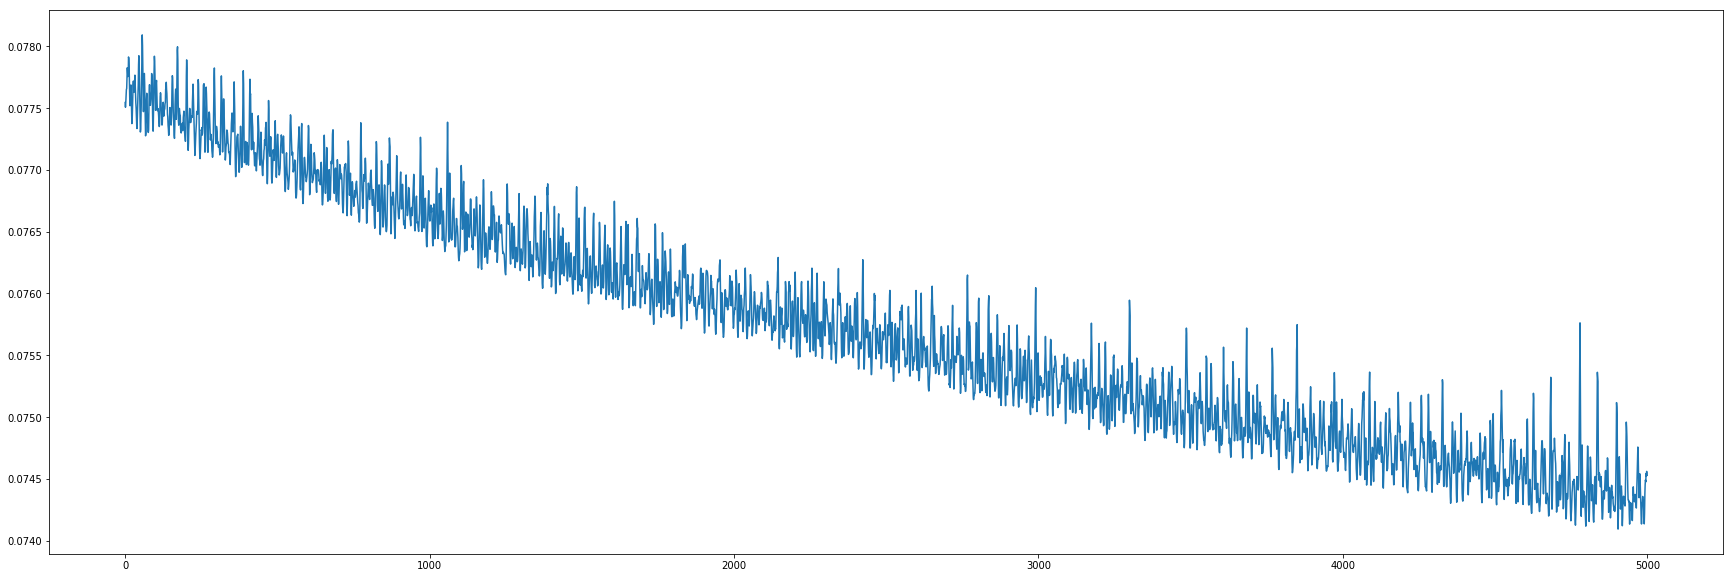

In [36]:
plt.plot(losses)
plt.show()

测试这个从Q-Table里面学到的critic管用不管用

> **当把**

In [46]:
# test the trained critic network
def get_action(state):
    state = np.array(state).reshape([1, -1])
    preds = critic.predict(sess=sess, x=state)
    return np.argmax(preds)

steps = []
for _ in  range(100):
    env = Env(tweaked_times=3, tweaked_times_limit=6)
    state = env.reset()
    for t in itertools.count():
        action = get_action(state)
        state_prime, reward, done, _ = env.step(action)
        
        if done  or t > 10:
            steps.append(t + 1)
            break
        else:
            state = state_prime
np.mean(steps)

3.14

In [47]:
# test the trained critic network
def get_action(state):
    state = np.array(state).reshape([1, -1])
    preds = critic.predict(sess=sess, x=state)
    return np.argmax(preds)

steps = []
for _ in  range(100):
    env = Env(tweaked_times=4, tweaked_times_limit=6)
    state = env.reset()
    for t in itertools.count():
        action = get_action(state)
        state_prime, reward, done, _ = env.step(action)
        
        if done  or t > 10:
            steps.append(t + 1)
            break
        else:
            state = state_prime
np.mean(steps)

4.57

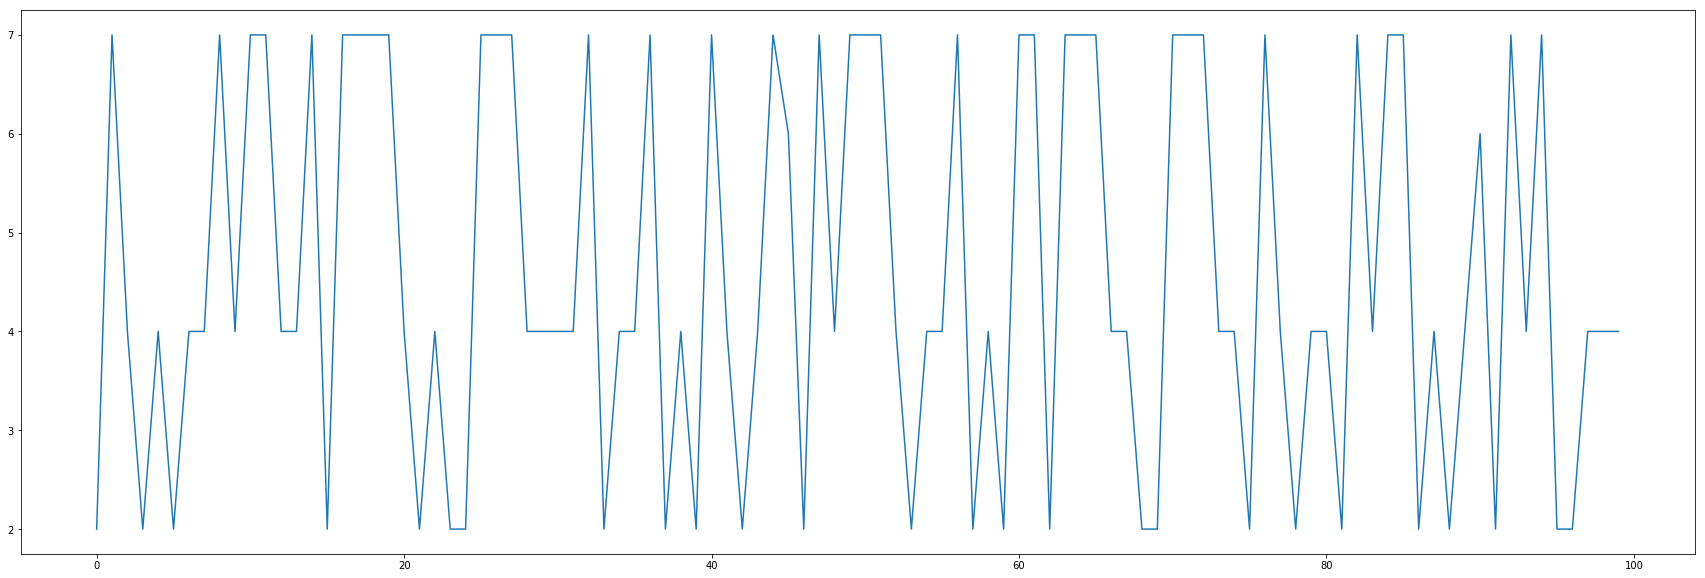

In [48]:
plt.plot(steps)
plt.show()

In [ ]:
#epsilon = .05
epsilon = 0
def get_action(state):
    """
    保证策略可以在贪婪性上做出变化
    此处的贪婪系数为0，是因为在这种环境下，贪婪策略不会导致智能体永远选择 次好的 动作(随着魔方初始旋转次数的增加，可以考虑改变贪婪系数探索更优策略的可能)
    """
    probs = np.ones(nA) * (epsilon / nA)
    probs[np.argmax(Q[state])] += (1. - epsilon)
    return np.random.choice(np.arange(nA), p=probs)

for n in range(0, 6): # n代表了初始化的魔方的旋转次数（如果直接选择较大的旋转次数，会增加训练的智能体的迷茫）
    for i in range(5 * (6 ** n)): # 5 * 6 ** n 稍微加强了智能体遍历各种魔方状态的可能（但是泛化能力几乎为零，这种方法类似于MC方法的暴力美学）
        # implement Sarsa with one Q in the above cell
        env = Env(tweaked_times=n, tweaked_times_limit=n * 2)
        num_episode = 100 # 一种初始状态下的最多的尝试次数

        discounter = 0.9 # temporal difference (TD) 中的折扣系数 lambda 参见 贝尔曼方程 bellman equation https://en.wikipedia.org/wiki/Bellman_equation
        sum_rewards = deque(maxlen=30)
        avg_sum_rewards = []
        nA = env.nA

        for episode_idx in range(num_episode):
            state = env.reset()
            action = get_action(state)
            
            td_errors = 0 # Q-V 的误差累积值

            rewards = 0
            for t in itertools.count():
                
                state_prime, reward, done, _ = env.step(action)
                rewards += reward
                action_prime = get_action(state_prime)
                td_error = reward + discounter * Q[state_prime][action_prime] - Q[state][action] # 参见 https://en.wikipedia.org/wiki/Temporal_difference_learning
                Q[state][action] += td_error * 0.3 # 0.3是学习率 eta
                
                td_errors += np.abs(td_error)

                if done:
                    break
                else:
                    state = state_prime
                    action = action_prime
            sum_rewards.append(rewards)
            avg_sum_rewards.append(np.mean(sum_rewards))
            
            print('\r {} {} {} {:>30}'.format(n, i, episode_idx, td_errors), end='')
            if td_errors < 10 ** -5: # 如果累积的误差已经很小的话，没有必要再持续尝试（state value近乎收敛）
                break


In [ ]:
# implement Sarsa with one Q in the above cell
env = Env(tweaked_times=5)
num_episode = 100
#epsilon = .05
epsilon = 0
discounter = 0.9
sum_rewards = deque(maxlen=30)
avg_sum_rewards = []
nA = env.nA

def get_action(state):
    probs = np.ones(nA) * (epsilon / nA)
    probs[np.argmax(Q[state])] += (1. - epsilon)
    return np.random.choice(np.arange(nA), p=probs)

for episode_idx in range(num_episode):
    state = env.reset()
    action = get_action(state)

    rewards = 0
    for t in itertools.count():
        state_prime, reward, done, _ = env.step(action)
        rewards += reward
        action_prime = get_action(state_prime)
        Q[state][action] += (reward + discounter * Q[state_prime][action_prime] - Q[state][action]) * 0.3

        if done:
            break
        else:
            state = state_prime
            action = action_prime
    sum_rewards.append(rewards)
    avg_sum_rewards.append(np.mean(sum_rewards))


plt.plot(avg_sum_rewards)
plt.show()